In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('data.csv')
# Iremos lidar apenas com números
data = data.select_dtypes(include='number').drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)
data_train = data[:500]
a_none = np.array(None)

In [4]:
'''Criando uma classe contendo algumas ferramentas para executar o least square'''
class LR():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.predictions=a_none
        self.parametros=a_none

        
    def least_square(self):
        # Transpose na matrix com as variáveis
        row_x = self.x.T
        dot_x = row_x.dot(self.x)
        invert_dotx = np.linalg.inv(dot_x)
        self.parametros = invert_dotx.dot(row_x).dot(self.y)
        
        return invert_dotx.dot(row_x).dot(self.y)

    def prediction(self, x=a_none):
        if self.parametros.all() == None:
            self.parametros = self.least_square()

        if x.all() == None:
            self.predictions = self.x.dot(self.parametros)
            return self.x.dot(self.parametros)
        else:
            return x.dot(self.parametros)

    def MSE(self, y_hat=a_none, y=a_none): 
        # Quantia de resultados
        if y_hat.all() == None:
            self.predictions = self.prediction(self.x)
            self.mse = (self.predictions - self.y).T.dot((self.predictions - self.y)) / len(self.y)
            return self.mse
        
        else:
            return (y_hat - y).T.dot((y_hat - y)) / len(y)
    
    '''Uma das formas de tentar selecionar os melhores features
    do modelo, assim podemos diminuir a quantia de variáveis'''
    def Forward_selection(self, n_feature):
        # Manter as dimensão do data-set
        axis_x, axis_y = self.x.shape
        # Copiar a data-set pois serão feitas alterações nele
        x = self.x
        # A cada iteração a variável escolhido virá para cá
        select_feature = np.ones([axis_x, n_feature+1])

        for i in range(1, n_feature+1):

            predict = np.inf

            # Mantém a primeira coluna para o intercept e das variáveis já selecionadas
            feature = np.array(select_feature[:,:i+1])
            select = 0
            for j in range(1, axis_y-i+1):

                feature[:, i] = x[:, j]
                mse = LR(feature, self.y).MSE()
                # Encontra a variável que produziu menor mse
                if (mse < predict):
                    predict = mse
                    select = j
            
            # Variável escolhida é adicionada ao data-set das escolhas
            select_feature[:, i] = x[:, select]
            # Variável escolhida é excluída do data-set das buscas
            x = np.delete(x, select, axis=1)

        return select_feature
    

    def Backward_selection(self, n_feature):
        # n_feature demonstra quantia de feature deleted
        
        # Manter as dimensão do data-set
        axis_x, axis_y = self.x.shape
        # Copiar a data-set pois serão feitas alterações nele
        x = self.x
        # A quantia de feature que teremos no data-set
        select_feature = axis_y - n_feature

        for i in range(1, select_feature):
            predict = -np.inf
            select = 0
         
            for j in range(1, axis_y-i+1):

                feature = np.delete(x, j, axis=1)
                mse = LR(feature, self.y).MSE()
                # Encontra a variável que produziu maior mse
                if (mse > predict):
                    predict = mse
                    select = j
            
            # Variável com maior mse é excluída do data-set
            x = np.delete(x, select, axis=1)

        return x

In [5]:
# Selecionando a coluna da variável e prediction
np_data = data_train[['price', 'spec_rating']].to_numpy()

np_x = np_data.T[1]
np_y = np_data.T[0]

# Adicionando uma coluna com 1 em np_x
np_x = np.array([np.ones(500), np_x]).T

dim_1 = LR(np_x, np_y) 

# Parâmetros calculado pelo least squre
B = dim_1.least_square()
# Prevendo resultado
y_hat = dim_1.prediction()
# Mean Square Error testando a qualidade do modelo
mse_dim1 = dim_1.MSE()
print(mse_dim1)

2457696370.0598817


In [6]:
'''A equação least square para mais de uma variável não é a mesma casos os dados
não sejam transformados, no least square há uma operação entre variáveis chamada
inner product que resultam em 0 casos os dados são ortogonais, assim iremos transforma-los
em ortogonais para aproveitar a mesma equação do caso com 1 dimensão'''

def residual(u, v):
    return u - (projection(u, v))

def projection(u, v):
    return (np.dot(u,v) / np.dot(v,v)) * v

# Função para deixar os dados ortogonais
def gram_schmidt(dataset):

    orthogonal = pd.DataFrame()
    colunas = dataset.columns

    for i in range(len(colunas)):
        v = dataset.iloc[:, i]
        for j in range(i):
            proj = projection(dataset.iloc[:, i], orthogonal.iloc[:, j])
            v = v - proj
        orthogonal[colunas[i]] = v 
    return orthogonal

In [7]:
# Data com mais de 1 variável
data_train

,price,spec_rating,display_size,resolution_width,resolution_height,warranty
0,49900,73.000000,15.6,1920.0,1080.0,1
1,39900,60.000000,15.6,1920.0,1080.0,1
2,26990,69.323529,14.0,1920.0,1080.0,1
3,59729,66.000000,14.0,2240.0,1400.0,1
4,69990,69.323529,13.3,2560.0,1600.0,1
...,...,...,...,...,...,...
495,59900,69.323529,15.6,1920.0,1080.0,1
496,55990,69.323529,14.0,1920.0,1080.0,1
497,19990,69.323529,15.6,1920.0,1080.0,1
498,47990,63.000000,14.0,2160.0,1440.0,1


In [8]:
multi_data  = gram_schmidt(data_train)
# Os mesmos dados depois da ortogonalizados
multi_data

,price,spec_rating,display_size,resolution_width,resolution_height,warranty
0,49900,42.026128,-0.581678,-108.583224,-64.154312,-0.089732
1,39900,35.233317,2.294516,128.732709,28.460823,0.022862
2,26990,52.570327,-1.466991,113.034744,-58.454783,-0.012584
3,59729,28.925082,-0.558172,352.132971,92.852173,0.021250
4,69990,25.879415,-1.955616,612.913343,82.849719,0.013045
...,...,...,...,...,...,...
495,59900,32.142468,0.294784,-92.923241,-48.202254,-0.057162
496,55990,34.569479,-1.324436,-3.286348,-81.604057,-0.010939
497,19990,56.915359,0.098599,67.158648,-16.344064,-0.059426
498,47990,33.211701,0.059203,364.727842,202.802435,0.049160


In [9]:
# inner product entre as duas colunas resultando em um valor bem próximo de 0
sum(multi_data.iloc[:,4] * multi_data.iloc[:,2])

7.38766964269999e-11

In [10]:
# Separando as variáveis do predictor
x = multi_data.iloc[:,1:]

train_data = np.ones([500, 6])
train_data[:, 1:] = x

multi_dim = LR(train_data, np_y)

BB = multi_dim.least_square()
yy_hat = multi_dim.prediction(train_data)
mse_mult = multi_dim.MSE(yy_hat, np_y)
print("MSE test: ",mse_mult)

# Para melhor interpretação podemos usar o erro médio
erro_medio = np.mean(np_y - yy_hat) / np.mean(np_y)
print("erro médio :", erro_medio) 

MSE test:  26189451.566836577
erro médio : 7.054046990610018e-16


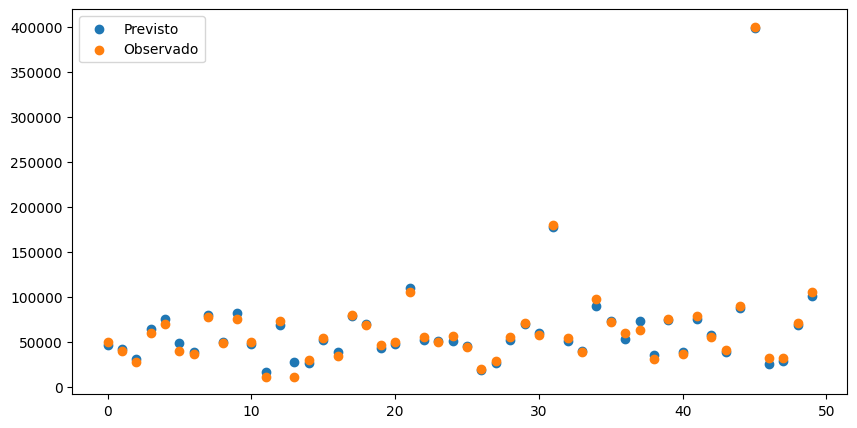

In [11]:
'''MSE não é a melhor métrica para interpretar a qualidade do modelo (outro problema para nós é a 
moeda utilizada, a escala é maior que o acostumado com o real). Uma solução seria criar métricas
que podemos interpretar, e em alguns casos figuras também podem podem ajudar na interpretação.
Foram selecionados os 50 primeiros dados para que coubessem na imagem, podemos ver que o modelo se sai 
bem em prever os preços'''

plt.figure(figsize=(10,5))
plt.scatter(range(50), yy_hat[:50], label='Previsto')
plt.scatter(range(50), np_y[:50], label='Observado')
plt.legend()

In [12]:
data_test = data[500:]
data_test = gram_schmidt(data_test)
# Separando as variáveis do predictor
x_test = data_test.iloc[:,1:]

y_test = data_test.iloc[:,0].to_numpy()
x_test = np.append(np.ones([len(x_test), 1]), x_test.to_numpy(), axis=1)

prediction_test = multi_dim.prediction(x_test)
mse_test = multi_dim.MSE(prediction_test, y_test)
print("MSE test: ", mse_test)

# Para melhor interpretação podemos usar o erro médio
erro_medio = np.mean(prediction_test - y_test) / np.mean(y_test)
print("erro médio :", erro_medio) 
# Um erro de mais ou menos 17%

MSE test:  475340050.5946491
erro médio : -0.17860955109236365


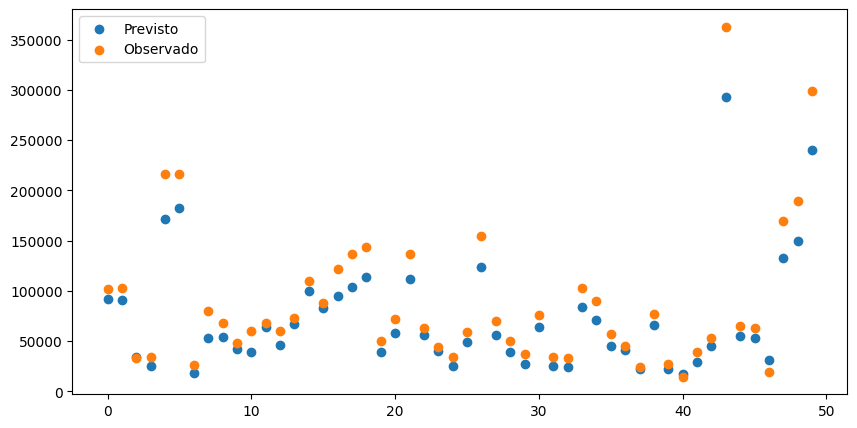

In [13]:
'''Pelo erro médio já podemos ter uma ideia que a previsão nos dados observados
terão uma queda de qualidade em relação aos dados do treino (coisa que não poderia
acontecer de forma tão brusca como ocorreu)'''
plt.figure(figsize=(10,5))
plt.scatter(range(50), prediction_test[:50], label='Previsto')
plt.scatter(range(50), y_test[:50], label='Observado')
plt.legend()

In [25]:
'''Podemos usar técnicas que buscam restringir o modelo tirar sua complexidade para que ele possa
generalizar melhor nos dados ainda não observados'''
mse_for = np.ones([len(train_data[0])-2, 1])

for i in range(1,len(train_data[0])-1):
    data_forward = multi_dim.Forward_selection(i)
    test_forward = LR(data_forward, np_y)

    BB_forward = test_forward.least_square()
    hat_forward = test_forward.prediction(data_forward)
    mse_forward = test_forward.MSE(hat_forward, np_y)
    print(f"MSE test com {i} variáveis: {mse_forward}")

    # Para melhor interpretação podemos usar o erro médio
    erro_medio = np.mean(np_y - hat_forward) / np.mean(np_y)
    print(f"Erro médio com {i} variáveis: {erro_medio}\n")
    mse_for[i-1] =  mse_forward

MSE test com 1 variáveis: 61368615.93835387
Erro médio com 1 variáveis: 2.3932649364346808e-17

MSE test com 2 variáveis: 30205907.462179832
Erro médio com 2 variáveis: 2.456138845781694e-16

MSE test com 3 variáveis: 27751978.69557727
Erro médio com 3 variáveis: 4.666866626047628e-16

MSE test com 4 variáveis: 26781508.362067297
Erro médio com 4 variáveis: -2.07686719907552e-16



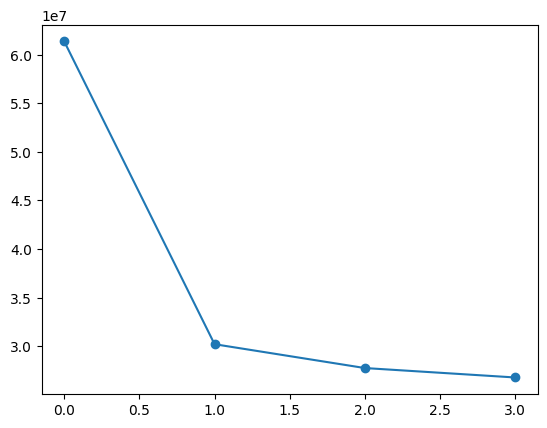

In [32]:
plt.plot(list(range(4)), mse_for, linestyle='-', marker='o')

In [33]:
data_forward = multi_dim.Forward_selection(2)
test_forward = LR(data_forward, np_y)

BB_forward = test_forward.least_square()
hat_forward = test_forward.prediction(data_forward)
mse_forward = test_forward.MSE(hat_forward, np_y)


# Para melhor interpretação podemos usar o erro médio
erro_medio = np.mean(np_y - hat_forward) / np.mean(np_y)


MSE test com 4 variáveis: 30205907.462179832
Erro médio com 4 variáveis: 2.456138845781694e-16

